In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import librosa
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from librosa import display
from scipy import signal
from scipy import fft
import glob
from PIL import Image
import pyaudio
import struct
import IPython.display as ipd
import math
#import tensorflow framework
import tensorflow as tf
from tensorflow.python.framework import ops

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#Data Exploration on two songs

In [2]:
#first load two musics into python and we can listen to the sample
ipd.Audio('/Users/changyuean/Python/Stanford/CS 229 Project/wav/2pac-trapped - 1.mp3')

In [3]:
ipd.Audio('/Users/changyuean/Python/Stanford/CS 229 Project/wav/10cc-for_you_and_i - 1.mp3')

In [4]:
#we can see that the length of these two music pieces are different. 
#In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
#first load the mp3 file as data and frequency
#according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
#downsampled each sound file to 22,050 Hz and merge stereo to mono
#I will replicate the same process
data1, sampling_rate1 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/2pac-trapped - 1.mp3',
                                        sr=22050, mono=True, duration = 3)
data2, sampling_rate2 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/10cc-for_you_and_i - 1.mp3',
                                        sr=22050, mono=True, duration = 3)

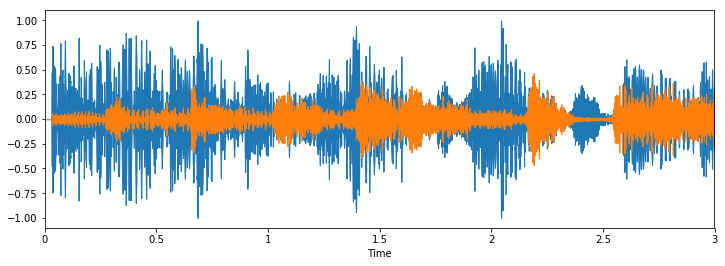

In [5]:
#visualize the wave plot
plt.figure(figsize=(12,4))
librosa.display.waveplot(data1, sr=sampling_rate1)
librosa.display.waveplot(data2, sr=sampling_rate2)

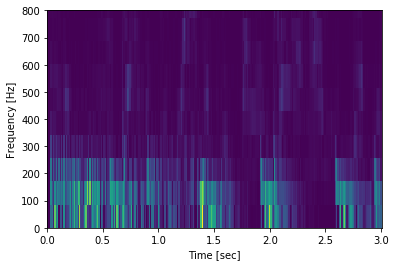

In [6]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies1, times1, spectrogram1 = signal.stft(data1,sampling_rate1, nperseg=256, noverlap=0)
plt.ylim(0, 800) 
plt.pcolormesh(times1, frequencies1, np.abs(spectrogram1))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(252, 380, 3)


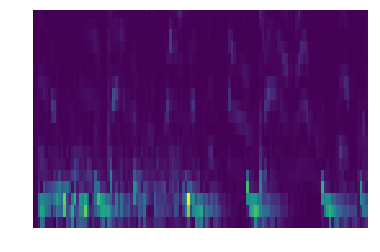

In [7]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies1, times1, spectrogram1 = signal.stft(data1,sampling_rate1, nperseg=512, noverlap=0)
plt.ylim(0, 800) 
plt.pcolormesh(times1, frequencies1, np.abs(spectrogram1))
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
im = Image.open('test.png')
rgb_im = im.convert('RGB')
print(np.shape(rgb_im))
#plt.show()

In [8]:


im = Image.open('test.png')
rgb_im = im.convert('RGB')
np.shape(rgb_im)

(252, 380, 3)

In [9]:
data1, sampling_rate1 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/5th_dimension-one_less_bell_to_answer - 4.mp3',
                                        sr=22050, mono=True, duration = 3)
data2, sampling_rate2 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/10cc-for_you_and_i - 2.mp3',
                                        sr=22050, mono=True, duration = 3)

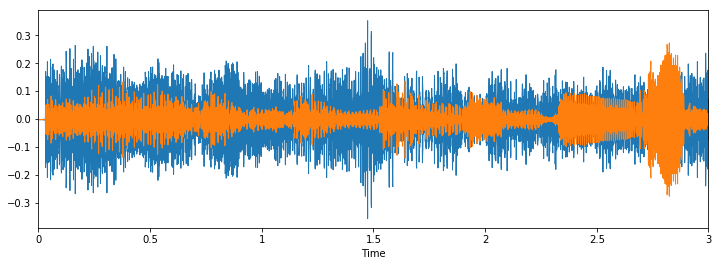

In [10]:
#visualize the wave plot
plt.figure(figsize=(12,4))
librosa.display.waveplot(data1, sr=sampling_rate1)
librosa.display.waveplot(data2, sr=sampling_rate2)

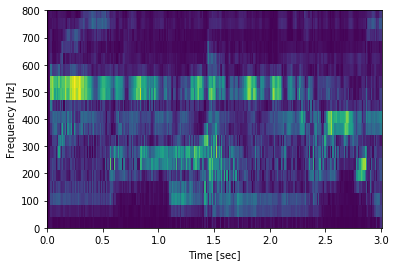

In [11]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies1, times1, spectrogram1 = signal.stft(data1,sampling_rate1, nperseg=512)
plt.ylim(0, 800) 
plt.pcolormesh(times1, frequencies1, np.abs(spectrogram1))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

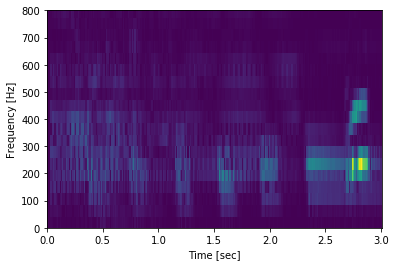

In [12]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies2, times2, spectrogram2 = signal.stft(data2,sampling_rate2, nperseg=512)
plt.ylim(0, 800) 
plt.pcolormesh(times2, frequencies2, np.abs(spectrogram2))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [13]:
#Emotion Labels for "2pac-trapped" and "10cc-for_you_and_i"
pac1 = pd.read_csv("/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/2pac-trapped.csv")
pac_song_emo1 = np.array(pac1["Song-Positive_Feelings"])
pac2 = pd.read_csv("/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/10cc-for_you_and_i.csv")
pac_song_emo2 = np.array(pac2["Song-Positive_Feelings"])

two_song_emo = np.append(pac_song_emo1,pac_song_emo2,axis =0)
two_song_emo = two_song_emo.reshape(1,2)
print(two_song_emo)

[[0 1]]


In [14]:
print(spectrogram1.shape)


(257, 260)


In [15]:
spect_subset1 = abs(spectrogram1[0:257,0:257])
spect_subset2 = abs(spectrogram2[0:257,0:257])

In [16]:
print(spect_subset1.shape)
print(spect_subset2.shape)

(257, 257)
(257, 257)


In [17]:
X1 = spect_subset1.reshape(-1,1)
X2 = spect_subset2.reshape(-1,1)

In [18]:
print(X1.shape)

(66049, 1)


In [19]:
X = np.append(X1,X2, axis=1)

In [20]:
print(X.shape)

(66049, 2)


#Generalize the Code to all data

In [21]:
# function to load label for a particular song
def load_label(label_dir, song_name):
    song_label = pd.read_csv(label_dir + song_name + ".csv")
    label = np.array(song_label["Song-Positive_Feelings"])
    return label

In [22]:
#function to read the mp3 data and pre-process it
def mp3_load_and_preprocess(data_dir, file_list, label_dir, segment_len =1024):
    
    songs = [line.rstrip('\n') for line in open(data_dir + file_list)]
    num_songs = len(songs)
    song_data_len = (int(segment_len/2) + 1)**2
    X = np.empty((song_data_len, num_songs))
    Y = np.empty((1, num_songs))
    #print(num_songs)
    #print(song_data_len)
    
    song_idx = 0
    for s in songs:
        #In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
        #first load the mp3 file as data and frequency
        #according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
        #downsampled each sound file to 22,050 Hz and merge stereo to mono
        #I will replicate the same process
        song_data, sampling_rate = librosa.core.load(data_dir + s, sr=22050, mono=True, duration =3 )
        
        #according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
        frequencies, times, spectrogram = signal.stft(song_data,sampling_rate, nperseg=segment_len)
        # make the spectrogram a K x K matrix, with K = segment_len/2
        spect_dim = int(segment_len/2) + 1
        spect_subset = abs(spectrogram[0:spect_dim,0:spect_dim])
        spect_reshaped = spect_subset.reshape(-1,)
        
        X[:,song_idx] = spect_reshaped
        
        #get label for this song
        song_name_parts = s.split(" ") # split name based on spaces
        song_base_name = song_name_parts[0]
        label = load_label(label_dir, song_base_name)
        
        # add label to Y
        Y[:,song_idx] = label
        
        song_idx += 1
        
    return X, Y


In [23]:
# load and pre-process data
data_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/wav/"
file_list = "mp3.txt"
label_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/"

X, Y = mp3_load_and_preprocess(data_directory, file_list, label_directory, segment_len=512)
print(X.shape)
print(Y.shape)
print(Y)

(66049, 3223)
(1, 3223)
[[1. 1. 1. ... 0. 0. 0.]]


In [24]:
#split the data to train and test set
def data_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.1, random_state=0)
    X_train = X_train.T
    X_test = X_test.T
    Y_train = Y_train.T
    Y_test = Y_test.T
    return X_train, X_test, Y_train, Y_test

In [25]:
def initialize(X):
    W = np.random.randn(X.shape[0],1)
    b = np.zeros(1)
    return W, b

In [26]:
def sigmoid(X, W, b):
    Z = np.dot(W.T,X)+b
    A = 1/ (1+np.exp(-Z))
    return A

In [27]:
def cost_function(X, Y, W, b):
    m = X.shape[0]
    A = sigmoid(X, W, b)
    cost = (-1/m)*np.sum(np.dot(Y,np.log(A).T)+np.dot(1-Y,np.log(1-A).T))
    dW = np.dot(X,(A-Y).T)
    db = np.sum(A-Y)
    grads = {"dW":dW, 
             "db":db}
    return cost, grads

In [28]:
def optimize(W, b, X, Y, learning_rate, beta):
    
    cost, grads = cost_function(X, Y, W, b)
    #update the W and b by using momentum
    v = grads["dW"]
    W = W - learning_rate*v
    b = b - learning_rate*grads["db"]
 
    
    cost_list = []
    cost_list.append(cost)
    params = {}
    prev_cost = None
    threshold = 1e-15
    iteration = 1
    while ((prev_cost is None or (abs(cost - prev_cost)>threshold)) and iteration<800):
        prev_cost = cost
        cost, grads = cost_function(X, Y, W, b)
        v = beta*v + (1-beta)*grads["dW"]
        W = W - learning_rate*v
        b = b - learning_rate*grads["db"]
        cost_list.append(cost)
        iteration = iteration+1
        if iteration%10==0:
            print("Cost after iteration %i: %f" %(iteration, cost))
    
    params["W"] = W
    params["b"] = b
    params["number of iterations"] = iteration
    
    return params, cost_list

In [29]:
def prediction(params, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    A = sigmoid(X, params["W"], params["b"])
    
    for i in range(A. shape[1]):
        if A[0,i]>0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [30]:
def confusion_matrix(Y_pred, Y_test):
    
    conf_matrix = {}
    TPcount = 0
    FPcount = 0
    FNcount = 0
    TNcount = 0
    
    for i in range(Y_test.shape[1]):
        if Y_pred[0,i]==1 and Y_test[0,i]==1:
            # true positive
            TPcount+=1
        elif Y_pred[0,i]==0 and Y_test[0,i]==1:
            FNcount+=1
        elif Y_pred[0,i]==1 and Y_test[0,i]==0:
            FPcount+=1
        else:
            TNcount+=1
    
    conf_matrix["True Positive"] = TPcount
    conf_matrix["False Positive"] = FPcount
    conf_matrix["False Negative"] = FNcount
    conf_matrix["True Negative"] = TNcount
    
    return conf_matrix
            

In [31]:
#define a main function to run the code
def main (X, Y, learning_rate = 0.001, beta = 0.9):
    np.random.seed(0)
    X_train, X_test, Y_train, Y_test = data_split(X, Y)
    W, b = initialize(X_train)
    #cost, grads = cost_function(X, Y, W, b, regularization)
    params, cost_list = optimize(W, b, X_train, Y_train, learning_rate, beta)
    
    Y_pred = prediction(params, X_test)
      
    c_matrix = confusion_matrix(Y_pred, Y_test)
    
    Accuracy = (c_matrix["True Positive"]+c_matrix["True Negative"])/Y_test.shape[1]
    print("Confusion Matrix:", c_matrix)
    print("Accuracy:", Accuracy)
    
    return params, cost_list, c_matrix

In [32]:
params, cost_list, c_matrix = main (X, Y, learning_rate = 0.001, beta = 0.9)

Cost after iteration 10: 0.085693
Cost after iteration 20: 0.057462
Cost after iteration 30: 0.040444
Cost after iteration 40: 0.036856
Cost after iteration 50: 0.035562
Cost after iteration 60: 0.034819
Cost after iteration 70: 0.034358
Cost after iteration 80: 0.033965
Cost after iteration 90: 0.033596
Cost after iteration 100: 0.033249
Cost after iteration 110: 0.032921
Cost after iteration 120: 0.032609
Cost after iteration 130: 0.032311
Cost after iteration 140: 0.032026
Cost after iteration 150: 0.031752
Cost after iteration 160: 0.031490
Cost after iteration 170: 0.031238
Cost after iteration 180: 0.030995
Cost after iteration 190: 0.030761
Cost after iteration 200: 0.030536
Cost after iteration 210: 0.030318
Cost after iteration 220: 0.030108
Cost after iteration 230: 0.029904
Cost after iteration 240: 0.029707
Cost after iteration 250: 0.029517
Cost after iteration 260: 0.029332
Cost after iteration 270: 0.029152
Cost after iteration 280: 0.028978
Cost after iteration 290: 0.0

Text(0,0.5,'cost')

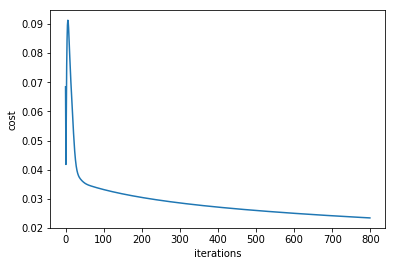

In [33]:
plt.plot(cost_list)
plt.xlabel("iterations")
plt.ylabel("cost")

#Apply Support Vector Machine with the music data

In [34]:
from sklearn.svm import SVC

In [35]:
model = SVC(kernel='sigmoid', C=0.1, probability=True)

In [36]:
#reshape Y from (1,3223) to (3223,)
X_train, X_test, Y_train, Y_test = data_split(X, Y)

In [37]:
print(X_train.shape)
print(Y_train.shape)

Y_train = Y_train.reshape(2900,)

(66049, 2900)
(1, 2900)


In [39]:
#fit SVM Model
model.fit(X_train.T, Y_train.T)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
pred = model.predict(X_test.T)

In [42]:
Y_test = Y_test.reshape(323,)

In [43]:
#calculate the confusion matrix and accuracy
TP = 0
TN = 0
FP = 0
FN = 0
confusion_matrix = {}

for i in range(pred.shape[0]):
    if pred[i]==1 and Y_test[i]==1:
        TP += 1
    elif pred[i]==0 and Y_test[i]==0:
        TN += 1
    elif pred[i]==1 and Y_test[i]==0:
        FP += 1
    else:
        FN += 1
        
confusion_matrix["True Positive"] = TP
confusion_matrix["True Negative"] = TN
confusion_matrix["False Positive"] = FP
confusion_matrix["False Negative"] = FN

Accuracy = (TP+TN)/(TP+TN+FP+FN)

print(confusion_matrix)
print(Accuracy)




{'True Positive': 189, 'True Negative': 0, 'False Positive': 134, 'False Negative': 0}
0.5851393188854489


---

Start to build convolutional neural network

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [45]:
model = Sequential()
spect_subset2 = spect_subset2.reshape(257,257,1)

In [46]:
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=spect_subset2.shape))

In [47]:
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [48]:
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [49]:
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(2, activation='softmax'))

---

Using Tensorflow to Build Convolutional Neural Network

In [50]:
#define a function to load the data without flattening the data
# function to load label for a particular song
def load_label_cnn(label_dir, song_name):
    song_label = pd.read_csv(label_dir + song_name + ".csv")
    label = np.array(song_label["Song-Positive_Feelings"])
    return label

In [51]:
#function to read the mp3 data and pre-process it
def mp3_load_and_preprocess_cnn(data_dir, file_list, label_dir, segment_len =1024, y_lim=600):
    
    songs = [line.rstrip('\n') for line in open(data_dir + file_list)]
    num_songs = len(songs)
    #song_data_len = (int(segment_len/2) + 1)
    # each spectrogram dimension is (252, 381, 3)
    x_height = 200
    x_width = 300
    x_rgb = 3
    X = np.empty((num_songs, x_height, x_width, x_rgb))
    Y = np.empty((num_songs,1))
    #print(num_songs)
    #print(song_data_len)
    
    song_idx = 0
    for s in songs:
        print(s)
        s_nopng = os.path.splitext(s)[0]
        s_spec = s_nopng + "_spec.png"
        
        # if we've already converted to spectrogram, all we need to do is load it
        if(os.path.isfile(s_spec)):
            print("- Spectrogram Exists -")
            im = Image.open(s_spec) # open the spectrogram image
            rgb_im = im.convert('RGB')
            rgb_crop = rgb_im.crop((0,0,x_width, x_height))
            X[song_idx,:,:,:] = rgb_crop
        else: # convert to spectrogram
            #In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
            #first load the mp3 file as data and frequency
            #according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
            #downsampled each sound file to 22,050 Hz and merge stereo to mono
            #I will replicate the same process
            song_data, sampling_rate = librosa.core.load(data_dir + s, sr=22050, mono=True, duration =3 )
        
            #according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
            frequencies, times, spectrogram = signal.stft(song_data,sampling_rate, nperseg=segment_len)
            plt.pcolormesh(times, frequencies, np.abs(spectrogram)) # plot the spectrogram
            plt.ylim(0, y_lim)
            plt.axis('off') # remove the axis from the spectrogram image
            plt.savefig(s_spec, bbox_inches='tight', pad_inches=0) # save the spectrogram image
            im = Image.open(s_spec) # open the spectrogram image
            rgb_im = im.convert('RGB')
            rgb_crop = rgb_im.crop((0,0,x_width, x_height))
            #print(np.shape(rgb_crop))
            X[song_idx,:,:,:] = rgb_crop
        
        
        #get label for this song
        song_name_parts = s.split(" ") # split name based on spaces
        song_base_name = song_name_parts[0]
        label = load_label_cnn(label_dir, song_base_name)
        
        # add label to Y
        Y[song_idx] = label
        
        song_idx += 1
        
    return X, Y

In [52]:
# function to load the spectrograms into data once mp3_load_and_preprocess has already been run once
def load_spectrograms_cnn(data_dir, file_list, label_dir, segment_len =1024, y_lim=600):
    
    songs = [line.rstrip('\n') for line in open(data_dir + file_list)]
    num_songs = len(songs)
    x_height = 200
    x_width = 300
    x_rgb = 3
    X = np.empty((num_songs, x_height, x_width, x_rgb))
    Y = np.empty((num_songs,1))
    
    song_idx = 0
    for s in songs:
        #s_spec = s_nopng + "_spec.png"
        im = Image.open(s) # open the spectrogram image
        rgb_im = im.convert('RGB')
        rgb_crop = rgb_im.crop((0,0,x_width, x_height))
        X[song_idx,:,:,:] = rgb_crop
        
        #get label for this song
        song_name_parts = s.split(" ") # split name based on spaces
        song_base_name = song_name_parts[0]
        label = load_label_cnn(label_dir, song_base_name)
        
        # add label to Y
        Y[song_idx] = label
        
        song_idx += 1
        
    return X, Y

In [ ]:
# load and pre-process data
data_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/wav/"
file_list = "mp3.txt"
label_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/"

X, Y = mp3_load_and_preprocess_cnn(data_directory, file_list, label_directory, segment_len=512, y_lim=600)
print(np.shape(X))
print(Y.shape)
print(Y)

In [53]:
# the above code takes forever to run because memory becomes full and it slows down
# so instead we can load the partial dataset of those songs already processed

# load data already processed
data_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/"
file_list = "spect.txt"
label_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/"

X,Y = load_spectrograms_cnn(data_directory, file_list, label_directory)
print(np.shape(X))
print(Y.shape)

(1930, 200, 300, 3)
(1930, 1)


In [54]:
#Normalize the input X data
X_norm = X/255.
print(X_norm.shape)
print(Y)

(1930, 200, 300, 3)
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [55]:
#call the data split function above to split into train and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.1, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(1737, 200, 300, 3)
(193, 200, 300, 3)
(1737, 1)
(193, 1)


In [56]:
#create tensorflow 
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [57]:
#initialize parameters
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [10,10,3,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [5,5,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters 

In [58]:
#define forward propogation
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P, num_outputs=1, activation_fn=None)
    ### END CODE HERE ###

    return Z3
    

The Random Mini Batches Code is obtained from Coursera Deep Learning Course

In [59]:
def random_mini_batches(X, Y, mini_batch_size = 16, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that your "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [60]:
#define a function to calculate the mean loss of sigmoid function
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z3, labels = Y))
        
    return cost 

In [75]:
#run the CNN model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 32, minibatch_size = 16, print_cost = True):

    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    print("Running forward propagation...")
    Z3 = forward_propagation(X, parameters)
    print("Z3 shape: ", np.shape(Z3))
    print("Z3: ", Z3)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        print("Running backpropagation...")
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.greater(Z3, 0.5)
        correct_prediction = tf.equal(predict_op, tf.cast(Y, tf.bool))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({x: X, y: Y}))
        
        return correct_prediction

Running forward propagation...
Z3 shape:  (?, 1)
Z3:  Tensor("fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Running backpropagation...
Cost after epoch 0: 0.703165


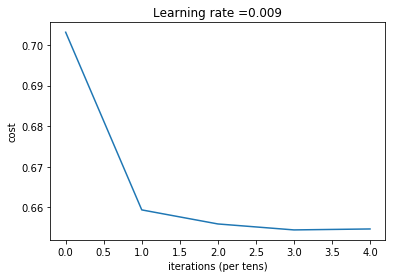

NameError: name 'x' is not defined

In [76]:
correct_prediction = model(X_train, Y_train, X_test, Y_test, num_epochs = 5)

In [71]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Running forward propagation...
Z3 shape:  (?, 1)
Z3:  Tensor("fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)
Running backpropagation...
Cost after epoch 0: 0.703165


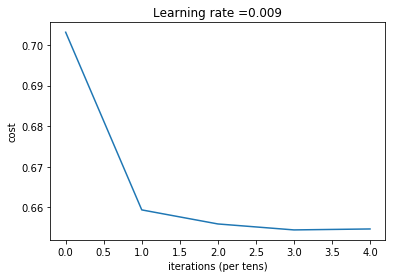

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,1]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_1', defined at:
  File "/Applications/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Applications/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Applications/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Applications/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Applications/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Applications/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Applications/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Applications/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Applications/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Applications/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-7a1e64f8f174>", line 1, in <module>
    correct_prediction_2 = model(X_train, Y_train, X_test, Y_test, num_epochs = 5)
  File "<ipython-input-73-502955a34d3a>", line 14, in model
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
  File "<ipython-input-56-a2f0298b9e1e>", line 5, in create_placeholders
    Y = tf.placeholder(tf.float32, [None, n_y])
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,1]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [74]:
correct_prediction_2 = model(X_train, Y_train, X_test, Y_test, num_epochs = 5)